In [26]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The time module is not an IPython extension.


Autosaving every 60 seconds


In [27]:
import pandas as pd
import numpy as np
import folium
import geojson
import geopandas
import osmnx as ox
import networkx as nx
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from exploration_utils import plot_counter, plot_counters, plot_locations, inspect_diff_area, plot_scatters
from exploration_utils import plot_speed_dayline, plot_flow_dayline, compute_highway_stats

RELEASE_PATH = Path('/private/data/mets10/release20221026_residential_unclassified/2022')
COUNTER_PATH = Path('/private/data/mets10/loop_counters')

lat_min, lat_max, lon_min, lon_max = (51.205, 51.7, -0.369, 0.067)

### Load road graph

In [28]:
edges_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'london' / 'road_graph_edges.parquet')
edges_df

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,gkey,gkey_duplicate
0,78112,25508583,129375498,32.2,20 mph,unclassified,False,nan,nan,19.391,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",409552002830522663,False
1,78112,25508584,129375498,32.2,20 mph,unclassified,False,nan,nan,63.845,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",-6417425712101911657,False
2,78112,25508584,4257258,32.2,20 mph,residential,True,nan,nan,102.544,"LINESTRING (-0.14579 51.52698, -0.14551 51.526...",-3748553887457448753,False
3,99936,2146383887,204647020,32.2,20 mph,unclassified,False,nan,nan,8.052,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",-388989128330894772,False
4,99936,4544836433,233623258,32.2,20 mph,unclassified,True,nan,nan,46.768,"LINESTRING (-0.15279 51.52361, -0.15294 51.523...",-7901792045498234530,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271112,10126902088,7156702760,619438421,32.2,20 mph,residential,False,nan,nan,23.106,"LINESTRING (-0.34015 51.60756, -0.34022 51.607...",-6683465919326087479,False
271113,10129130768,10129130769,1106958225,32.2,20 mph,residential,False,nan,nan,8.780,"LINESTRING (-0.33864 51.50776, -0.33876 51.50774)",2619412628269241113,False
271114,10129130768,1071593880,1106958224,32.2,20 mph,residential,False,nan,nan,104.562,"LINESTRING (-0.33864 51.50776, -0.33868 51.507...",-8212942379373624685,False
271115,10129130768,2195689218,1106958225,32.2,20 mph,residential,False,nan,nan,35.120,"LINESTRING (-0.33864 51.50776, -0.33839 51.507...",-8197480378525436937,False


### Load loop counter locations matched

In [29]:
counters_assigned_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'london' / 'counters_matched.parquet')
print(len(counters_assigned_df))
counters_assigned_df = counters_assigned_df[counters_assigned_df['way'] != -1]
counters_assigned_df

5964


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,5,51.575617,0.283162,-1,M25/5764B,[],[],-1,-1.000000,-1,-1,POINT (0.28316 51.57562)
1,8,51.433749,-0.538796,-1,M25/4876A,[],[],-1,-1.000000,-1,-1,POINT (-0.53880 51.43375)
2,14,51.408466,0.381381,-1,A2/8392M,[],[],-1,-1.000000,-1,-1,POINT (0.38138 51.40847)
3,24,51.520645,-2.049237,-1,M4/3479A,[],[],-1,-1.000000,-1,-1,POINT (-2.04924 51.52064)
4,25,51.664773,-0.493692,-1,M25/5135B,[],[],-1,-1.000000,-1,-1,POINT (-0.49369 51.66477)
...,...,...,...,...,...,...,...,...,...,...,...,...
5959,32/210,51.612580,-0.113407,-1,,"[(196428, 1745361161, 0), (1745285962, 1745285...","[0.5058183806568601, 10.5399731372893, 16.9187...","[51180740, 108469928, 51249389, 404260437, 404...",0.505818,196428,1745361161,POINT (-0.11341 51.61258)
5960,32/224,51.632029,-0.073554,-1,,"[(5308552473, 6583849322, 0), (26001619, 10526...","[2.110936163160965, 11.648444596432814]","[8122037, 183043102, 682948503]",2.110936,5308552473,6583849322,POINT (-0.07355 51.63203)
5961,32/225,51.631973,-0.073398,-1,,"[(26001619, 1052641793, 0), (5308552473, 65838...","[0.7067135283972795, 13.211708987076507]","[775324853, 1656423]",0.706714,26001619,1052641793,POINT (-0.07340 51.63197)
5962,32/228,51.629826,-0.097257,-1,,"[(256630996, 8085242318, 0), (8085242318, 2566...","[2.094607763208028, 2.094607763208028, 13.0407...","[867401512, 867401516, 867401518, 867401459, 8...",2.094608,256630996,8085242318,POINT (-0.09726 51.62983)


In [30]:
compute_highway_stats(counters_assigned_df, edges_df)

,count,share,share_full
highway,,,
motorway,398,10 %,10.410672
primary,1545,40 %,40.413288
residential,194,5 %,5.074549
secondary,249,7 %,6.513210
tertiary,349,9 %,9.128956
trunk,985,26 %,25.765106
unclassified,103,3 %,2.694219


In [31]:
counters_assigned_df = counters_assigned_df[(counters_assigned_df['way'] != -1) & (counters_assigned_df['way'] != '-1')]
counters_assigned_df

,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
5,28,51.268629,-0.166750,-1,M25/4490B,"[(1639045045, 202952, 0), (206223889, 16390449...","[1.7473350855586416, 22.314578360426612, 29.15...",23189325,1.747335,1639045045,202952,POINT (-0.16675 51.26863)
11,46,51.264317,-0.132305,-1,M25/4465A,"[(12079094, 202953, 0), (202952, 203009, 0)]","[2.453989539425953, 18.082068670467034]","[2714200, 108688595]",2.453990,12079094,202953,POINT (-0.13230 51.26432)
14,57,51.273244,0.063816,-1,M25/4322B,"[(203171, 170792507, 0), (1639108484, 203172, 0)]","[5.635538236864448, 20.39117466656207]","[10660889, 10660898, 16536383]",5.635538,203171,170792507,POINT (0.06382 51.27324)
19,75,51.259332,-0.108098,-1,M25/4447B,"[(203009, 12079111, 0), (12079109, 2015848786,...","[3.425799135308956, 18.37990609198298]","[4794119, 226518825, 682852587, 151074097, 108...",3.425799,203009,12079111,POINT (-0.10810 51.25933)
21,80,51.258246,-0.053938,-1,M25/4409B,"[(203108, 170644582, 0), (170644470, 163910846...","[0.5905465516563868, 15.031632632080552]","[10503271, 16536183, 16536392, 16536296, 16536...",0.590547,203108,170644582,POINT (-0.05394 51.25825)
...,...,...,...,...,...,...,...,...,...,...,...,...
5959,32/210,51.612580,-0.113407,-1,,"[(196428, 1745361161, 0), (1745285962, 1745285...","[0.5058183806568601, 10.5399731372893, 16.9187...","[51180740, 108469928, 51249389, 404260437, 404...",0.505818,196428,1745361161,POINT (-0.11341 51.61258)
5960,32/224,51.632029,-0.073554,-1,,"[(5308552473, 6583849322, 0), (26001619, 10526...","[2.110936163160965, 11.648444596432814]","[8122037, 183043102, 682948503]",2.110936,5308552473,6583849322,POINT (-0.07355 51.63203)
5961,32/225,51.631973,-0.073398,-1,,"[(26001619, 1052641793, 0), (5308552473, 65838...","[0.7067135283972795, 13.211708987076507]","[775324853, 1656423]",0.706714,26001619,1052641793,POINT (-0.07340 51.63197)
5962,32/228,51.629826,-0.097257,-1,,"[(256630996, 8085242318, 0), (8085242318, 2566...","[2.094607763208028, 2.094607763208028, 13.0407...","[867401512, 867401516, 867401518, 867401459, 8...",2.094608,256630996,8085242318,POINT (-0.09726 51.62983)


In [32]:
def way_ambiguity(ways, way_dists):
    way_dists = eval(way_dists)
    if len(way_dists) < 2:
#         print(f'{ways}: {way_dists}')
        return 10
    p = 0
    if way_dists[0] == way_dists[1] and len(way_dists) > 2:
        p = 1  # TODO use check for oneway here
    amb = (way_dists[p+1] - way_dists[p])
    if amb == 0:
        return 0
    amb =  way_dists[p] / amb
    if amb > 10:
        amb = 10
    return amb


counters_assigned_df['way_ambiguity'] = [way_ambiguity(w, wd) for w, wd in
    zip(counters_assigned_df['ways'], counters_assigned_df['way_dists'])]
counters_assigned_df

/usr/local/Caskroom/miniconda/base/envs/t4c/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry,way_ambiguity
5,28,51.268629,-0.166750,-1,M25/4490B,"[(1639045045, 202952, 0), (206223889, 16390449...","[1.7473350855586416, 22.314578360426612, 29.15...",23189325,1.747335,1639045045,202952,POINT (-0.16675 51.26863),0.084957
11,46,51.264317,-0.132305,-1,M25/4465A,"[(12079094, 202953, 0), (202952, 203009, 0)]","[2.453989539425953, 18.082068670467034]","[2714200, 108688595]",2.453990,12079094,202953,POINT (-0.13230 51.26432),0.157024
14,57,51.273244,0.063816,-1,M25/4322B,"[(203171, 170792507, 0), (1639108484, 203172, 0)]","[5.635538236864448, 20.39117466656207]","[10660889, 10660898, 16536383]",5.635538,203171,170792507,POINT (0.06382 51.27324),0.381924
19,75,51.259332,-0.108098,-1,M25/4447B,"[(203009, 12079111, 0), (12079109, 2015848786,...","[3.425799135308956, 18.37990609198298]","[4794119, 226518825, 682852587, 151074097, 108...",3.425799,203009,12079111,POINT (-0.10810 51.25933),0.229088
21,80,51.258246,-0.053938,-1,M25/4409B,"[(203108, 170644582, 0), (170644470, 163910846...","[0.5905465516563868, 15.031632632080552]","[10503271, 16536183, 16536392, 16536296, 16536...",0.590547,203108,170644582,POINT (-0.05394 51.25825),0.040893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959,32/210,51.612580,-0.113407,-1,,"[(196428, 1745361161, 0), (1745285962, 1745285...","[0.5058183806568601, 10.5399731372893, 16.9187...","[51180740, 108469928, 51249389, 404260437, 404...",0.505818,196428,1745361161,POINT (-0.11341 51.61258),0.050410
5960,32/224,51.632029,-0.073554,-1,,"[(5308552473, 6583849322, 0), (26001619, 10526...","[2.110936163160965, 11.648444596432814]","[8122037, 183043102, 682948503]",2.110936,5308552473,6583849322,POINT (-0.07355 51.63203),0.221330
5961,32/225,51.631973,-0.073398,-1,,"[(26001619, 1052641793, 0), (5308552473, 65838...","[0.7067135283972795, 13.211708987076507]","[775324853, 1656423]",0.706714,26001619,1052641793,POINT (-0.07340 51.63197),0.056514
5962,32/228,51.629826,-0.097257,-1,,"[(256630996, 8085242318, 0), (8085242318, 2566...","[2.094607763208028, 2.094607763208028, 13.0407...","[867401512, 867401516, 867401518, 867401459, 8...",2.094608,256630996,8085242318,POINT (-0.09726 51.62983),0.191355


<AxesSubplot:>

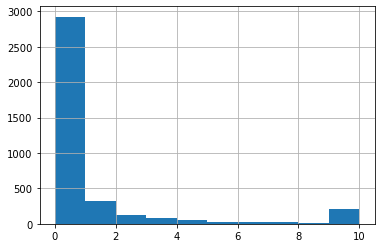

In [33]:
counters_assigned_df['way_ambiguity'].hist()

### Load loop counter speed values (WEBTRIS)

In [46]:
counter_speed_df = pd.read_parquet(COUNTER_PATH / 'london' / 'speed' / 'webtris_london_201907-202001.parquet')
counter_speed_df = counter_speed_df[
        (counter_speed_df['lat'] >= lat_min) & (counter_speed_df['lat'] <= lat_max) &
        (counter_speed_df['lon'] >= lon_min) & (counter_speed_df['lon'] <= lon_max)]
all_webtris_df = counter_speed_df
counter_speed_df

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day
20832,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:15,0,0.00000,0,2019-07-01
20833,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:30,0,0.00000,1,2019-07-01
20834,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:45,0,0.00000,2,2019-07-01
20835,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 01:00,0,0.00000,3,2019-07-01
20836,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 01:15,0,0.00000,4,2019-07-01
...,...,...,...,...,...,...,...,...,...,...
38683,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:00,347,106.21644,91,2020-01-31
38684,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:15,274,106.21644,92,2020-01-31
38685,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:30,184,102.99776,93,2020-01-31
38686,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31


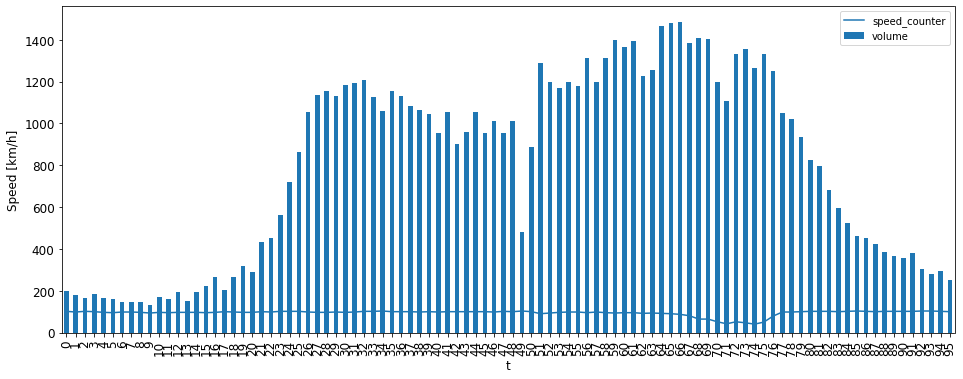

In [47]:
plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-22')], '6137', plot_volume=True)
plot_counter(counters_assigned_df, edges_df, '6137')

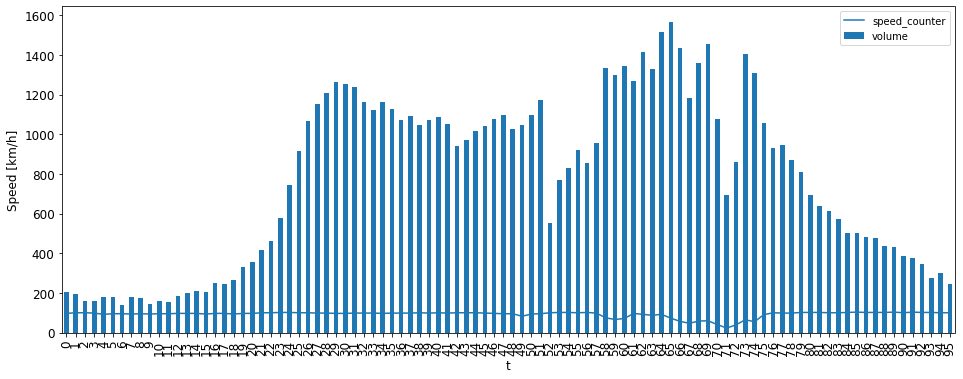

In [48]:
plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-29')], '6137', plot_volume=True)
plot_counter(counters_assigned_df, edges_df, '6137')

In [53]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2019-01-01')], '6137', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '6137')

In [ ]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2019-07-04')], '6137', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '6137')

In [54]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-29')], '1737', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '1737')

In [55]:
# Select a single day and merge with the locations
counter_speeds_oneday = counter_speed_df[counter_speed_df['day'] == '2020-01-29'].merge(
    counters_assigned_df[['id', 'way', 'u', 'v']], on=['id'])
counter_speeds_oneday

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day,way,u,v
0,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:15,0,0.00000,0,2020-01-29,"[10660889, 10660898, 16536383]",203171,170792507
1,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:30,0,0.00000,1,2020-01-29,"[10660889, 10660898, 16536383]",203171,170792507
2,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:45,0,0.00000,2,2020-01-29,"[10660889, 10660898, 16536383]",203171,170792507
3,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 01:00,0,0.00000,3,2020-01-29,"[10660889, 10660898, 16536383]",203171,170792507
4,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 01:15,0,0.00000,4,2020-01-29,"[10660889, 10660898, 16536383]",203171,170792507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38585,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:00,164,109.43512,91,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38586,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:15,128,107.82578,92,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38587,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:30,123,106.21644,93,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38588,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:45,134,102.99776,94,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761


In [56]:
def is_valid_counter(s):
    h = np.histogram(s, bins=2)
    return h[-1][-1]

invalid_counters = counter_speeds_oneday[['id', 'speed_counter']].groupby(by=['id']).agg(list).reset_index()
invalid_counters['shist'] = [is_valid_counter(s) for s in invalid_counters['speed_counter']]
invalid_counters = invalid_counters[invalid_counters['shist'] < 1]
invalid_counters

,id,speed_counter,shist
1,10071,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
3,10258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
4,10271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
6,10286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
9,10324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
...,...,...,...
381,963,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
382,9631,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
388,9762,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
394,981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5


In [57]:
counter_speeds_oneday = counter_speeds_oneday[~counter_speeds_oneday['id'].isin(invalid_counters['id'])]
counter_speeds_oneday

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day,way,u,v
96,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,"[2714200, 108688595]",12079094,202953
97,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,"[2714200, 108688595]",12079094,202953
98,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:45,69,98.16974,2,2020-01-29,"[2714200, 108688595]",12079094,202953
99,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 01:00,72,99.77908,3,2020-01-29,"[2714200, 108688595]",12079094,202953
100,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 01:15,53,93.34172,4,2020-01-29,"[2714200, 108688595]",12079094,202953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38585,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:00,164,109.43512,91,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38586,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:15,128,107.82578,92,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38587,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:30,123,106.21644,93,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761
38588,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:45,134,102.99776,94,2020-01-29,"[4546787, 4546788, 4546789, 382703210, 4546652...",27461204,197761


### Load T4c speed values

In [64]:
speed_files = sorted(list((RELEASE_PATH / 'speed_classes' / 'london').glob('*.parquet')))
speed_files[-3:]

[PosixPath('/private/data/mets10/release20221026_residential_unclassified/2022/speed_classes/london/speed_classes_2020-01-29.parquet'),
 PosixPath('/private/data/mets10/release20221026_residential_unclassified/2022/speed_classes/london/speed_classes_2020-01-30.parquet'),
 PosixPath('/private/data/mets10/release20221026_residential_unclassified/2022/speed_classes/london/speed_classes_2020-01-31.parquet')]

In [65]:
# speed_df = pd.read_parquet(speed_files[0])
speed_df = pd.read_parquet(RELEASE_PATH / 'speed_classes' / 'london' / 'speed_classes_2020-01-29.parquet')
speed_df = speed_df.rename(columns={'median_speed_kph': 'speed_probes'})
speed_df

,u,v,gkey,osmid,day,t,volume_class,volume,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,78112,25508583,409552002830522663,129375498,2020-01-29,3,5,7.0,32.941176,28.862745,11.509921,45.176471
1,78112,25508583,409552002830522663,129375498,2020-01-29,19,3,4.0,19.294118,19.294118,5.647059,45.176471
2,78112,25508583,409552002830522663,129375498,2020-01-29,29,5,5.0,42.823529,42.509804,1.173853,45.176471
3,78112,25508583,409552002830522663,129375498,2020-01-29,31,1,1.0,42.823529,42.823529,0.000000,45.176471
4,78112,25508583,409552002830522663,129375498,2020-01-29,34,3,4.0,38.588235,37.333333,3.943468,45.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
5003548,10129130768,1071593880,-8212942379373624685,1106958224,2020-01-29,17,5,7.0,10.117647,10.117647,1.647059,16.470588
5003549,10129130768,1071593880,-8212942379373624685,1106958224,2020-01-29,35,3,4.0,9.882353,9.882353,9.882353,16.470588
5003550,10129130768,1071593880,-8212942379373624685,1106958224,2020-01-29,49,3,4.0,11.058824,11.058824,6.352941,16.470588
5003551,10129130768,2195689218,-8197480378525436937,1106958225,2020-01-29,58,5,10.0,2.000000,2.000000,2.000000,8.941176


# Compare Speed Values

In [66]:
speeds_merged = counter_speeds_oneday.merge(speed_df, on=['u', 'v', 't'])
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,v,gkey,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,202953,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000
1,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:15,94,102.99776,0,2020-01-29,...,202953,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000
2,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,202953,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,202953,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.000000
4,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:30,77,101.38842,1,2020-01-29,...,202953,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22928,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 22:45,68,67.59228,90,2020-01-29,...,197757,-5745838862802199838,4277064,2020-01-29,5,13.0,80.941176,83.338936,19.928266,101.647059
22929,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:00,64,70.81096,91,2020-01-29,...,197757,-5745838862802199838,4277064,2020-01-29,5,9.0,81.882353,81.852941,33.011362,101.647059
22930,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:15,91,72.42030,92,2020-01-29,...,197757,-5745838862802199838,4277064,2020-01-29,5,11.0,87.764706,75.921569,25.801895,101.647059
22931,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:30,75,70.81096,93,2020-01-29,...,197757,-5745838862802199838,4277064,2020-01-29,5,8.0,115.764706,94.588235,29.240158,101.647059


In [68]:
speeds_merged = speeds_merged[speeds_merged['volume_y'] > 0]
speeds_merged['diff'] = (speeds_merged['speed_counter'] - speeds_merged['speed_probes']).abs()
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,gkey,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000,3.326444
1,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:15,94,102.99776,0,2020-01-29,...,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000,7.938936
2,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.000000,7.938936
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.000000,4.795694
4,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:30,77,101.38842,1,2020-01-29,...,3625310741553543310,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.000000,9.623714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22928,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 22:45,68,67.59228,90,2020-01-29,...,-5745838862802199838,4277064,2020-01-29,5,13.0,80.941176,83.338936,19.928266,101.647059,13.348896
22929,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:00,64,70.81096,91,2020-01-29,...,-5745838862802199838,4277064,2020-01-29,5,9.0,81.882353,81.852941,33.011362,101.647059,11.071393
22930,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:15,91,72.42030,92,2020-01-29,...,-5745838862802199838,4277064,2020-01-29,5,11.0,87.764706,75.921569,25.801895,101.647059,15.344406
22931,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 23:30,75,70.81096,93,2020-01-29,...,-5745838862802199838,4277064,2020-01-29,5,8.0,115.764706,94.588235,29.240158,101.647059,44.953746


In [69]:
len(speeds_merged['id'].unique())

249

In [70]:
counters_speed_df = speeds_merged[['id', 'u', 'v', 'way']].groupby(by=['id', 'u', 'v', 'way']).count().reset_index()
counters_speed_df['way'] = counters_speed_df['way'].astype(str)
counters_stats_df = counters_speed_df.merge(edges_df, left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
counters_stats_df = counters_stats_df[['id', 'highway']]
counters_stats_df['hwc'] = counters_stats_df['highway'].str.replace('_link', '')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')
highway_stats = counters_stats_df[['hwc', 'highway']].groupby(by=['hwc']).count().reset_index()
highway_stats = highway_stats.rename(columns={'highway': 'count'})
highway_stats = highway_stats.rename(columns={'hwc': 'highway'})
highway_stats['share'] = (highway_stats['count'] / len(counters_stats_df) * 100).round()
highway_stats = highway_stats.set_index('highway')
highway_stats.style.format({'share': "{:.0f} %"})

<ipython-input-70-e6105a1059f2>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
<ipython-input-70-e6105a1059f2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')


,count,share
highway,,
motorway,237,95 %
trunk,12,5 %


<AxesSubplot:>

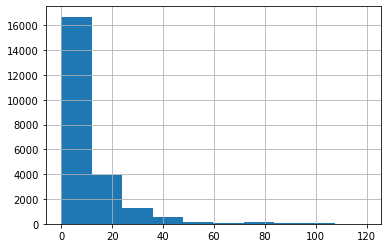

In [71]:
speeds_merged['diff'].hist()

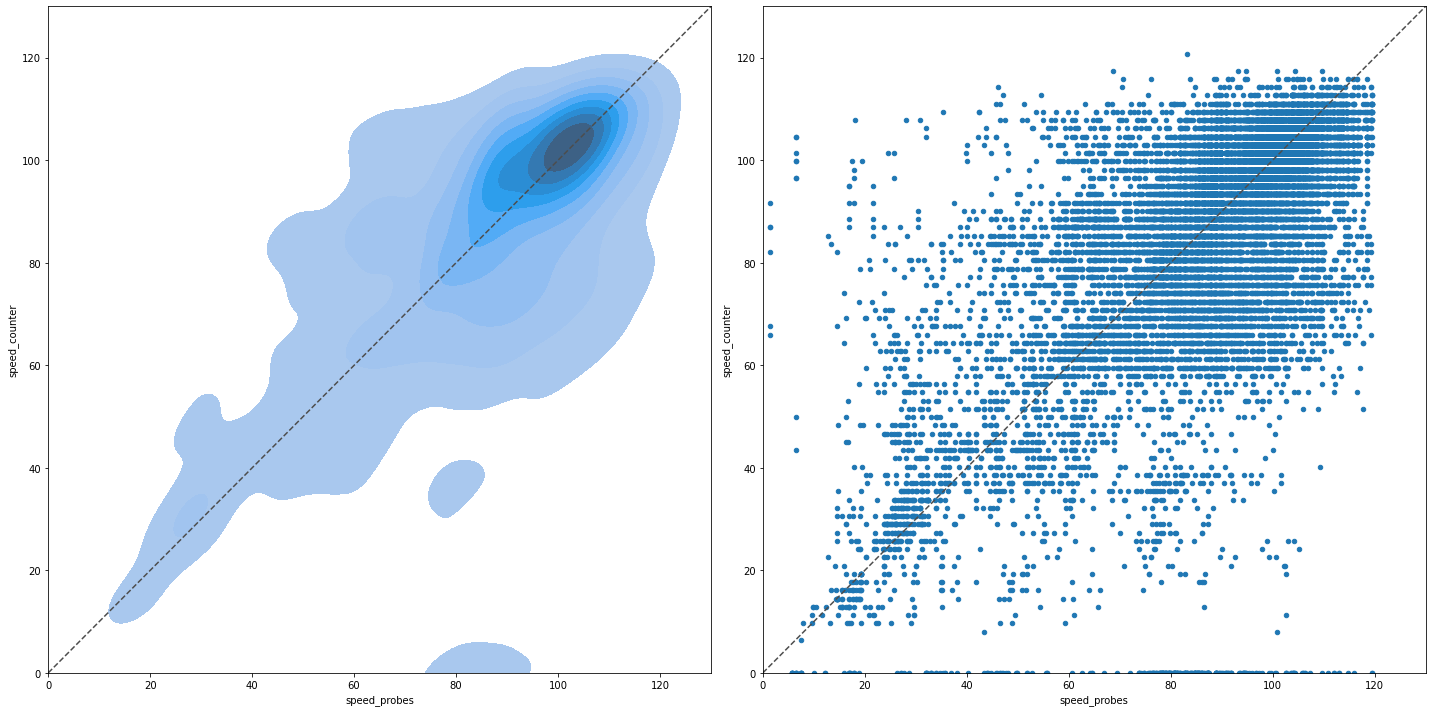

In [72]:
plot_scatters(speeds_merged)

<AxesSubplot:>

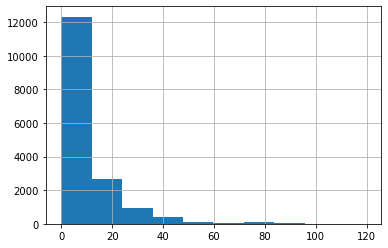

In [73]:
speeds_merged_day = speeds_merged[(speeds_merged['t'] > 23) & (speeds_merged['t'] < 92)]
speeds_merged_day['diff'].hist()

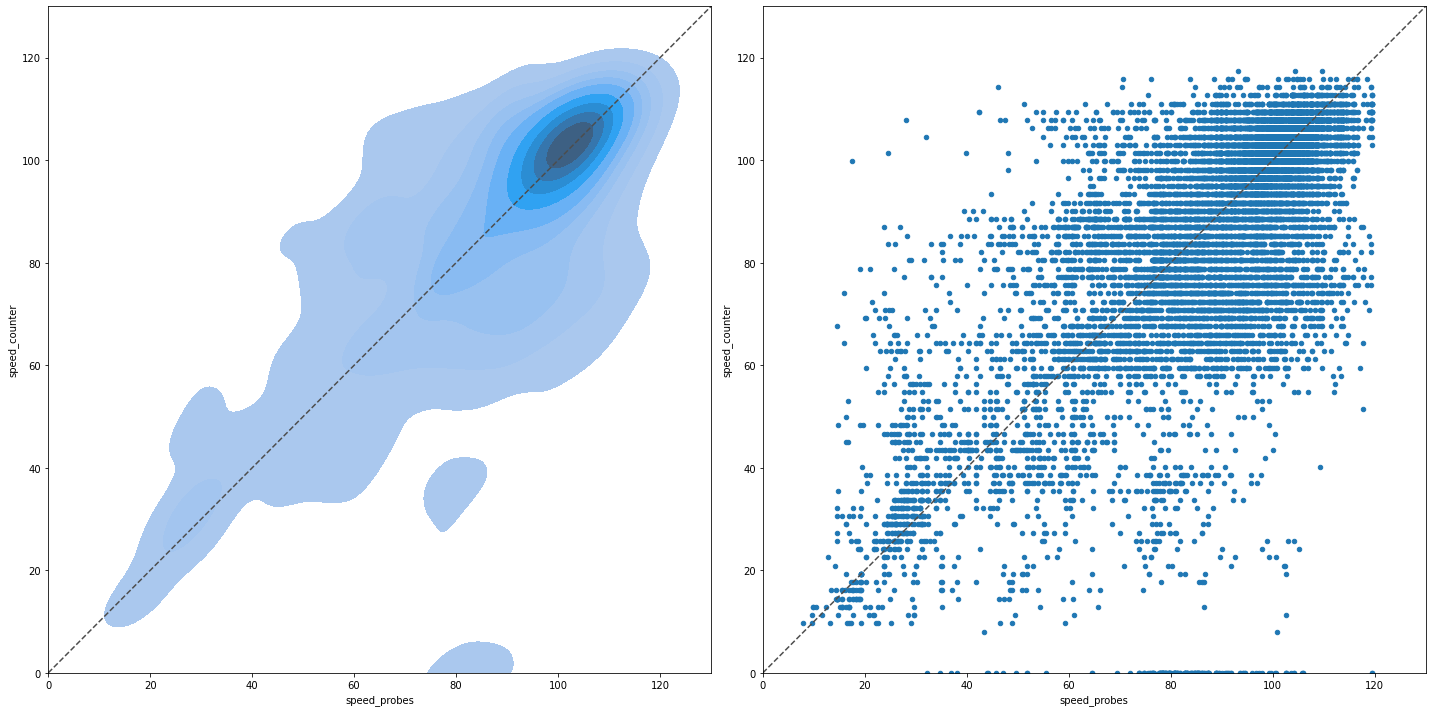

In [74]:
plot_scatters(speeds_merged_day)

Area (x in (0, 120), y in (0, 120) contains 22932 / 22933 readings (100.00%)
Readings are on 249 / 249 locations


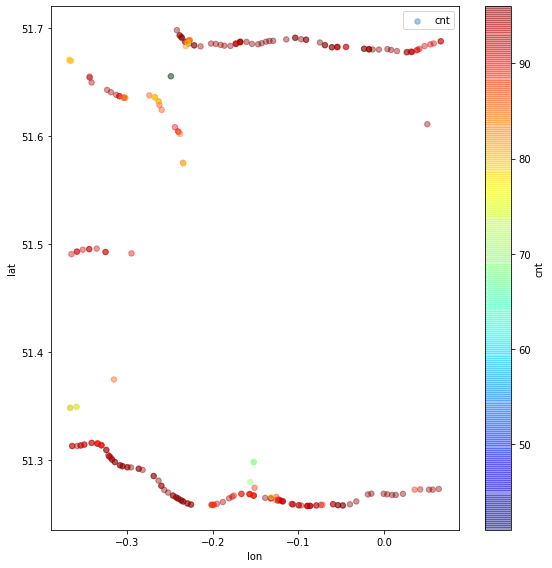

In [75]:
_ = inspect_diff_area(speeds_merged, 0, 120, 0, 120)

Area (x in (0, 120), y in (0, 120) contains 22932 / 22933 readings (100.00%)
Readings are on 249 / 249 locations


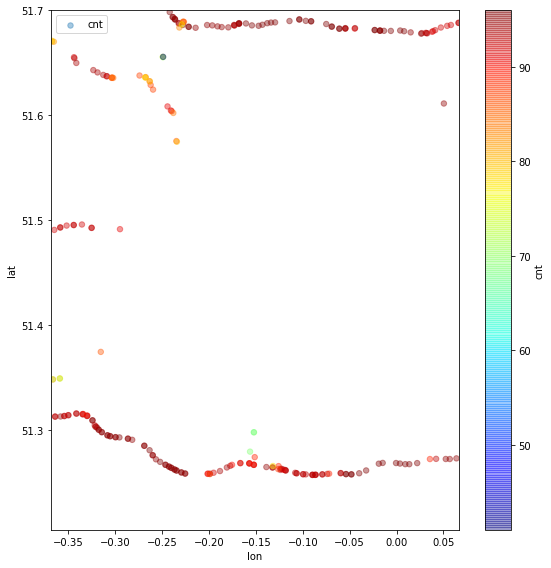

In [76]:
_ = inspect_diff_area(speeds_merged, 0, 120, 0, 120, bbox_city='london')

In [81]:
speeds_merged.to_parquet(COUNTER_PATH / 'london' / 'speeds_merged_london.parquet', compression="snappy")

22933


<AxesSubplot:>

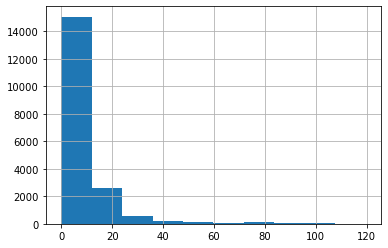

In [78]:
# hw_df = edges_df[['u', 'v', 'gkey', 'highway']]#.groupby(by=['u', 'v', 'gkey', 'highway']).count().reset_index()
speeds_merged_nolink = speeds_merged.merge(edges_df[['u', 'v', 'gkey', 'highway']], on=['u', 'v', 'gkey'])
print(len(speeds_merged_nolink))
speeds_merged_nolink = speeds_merged_nolink[(~speeds_merged_nolink['highway'].str.contains('_link'))]
speeds_merged_nolink['diff'].hist()

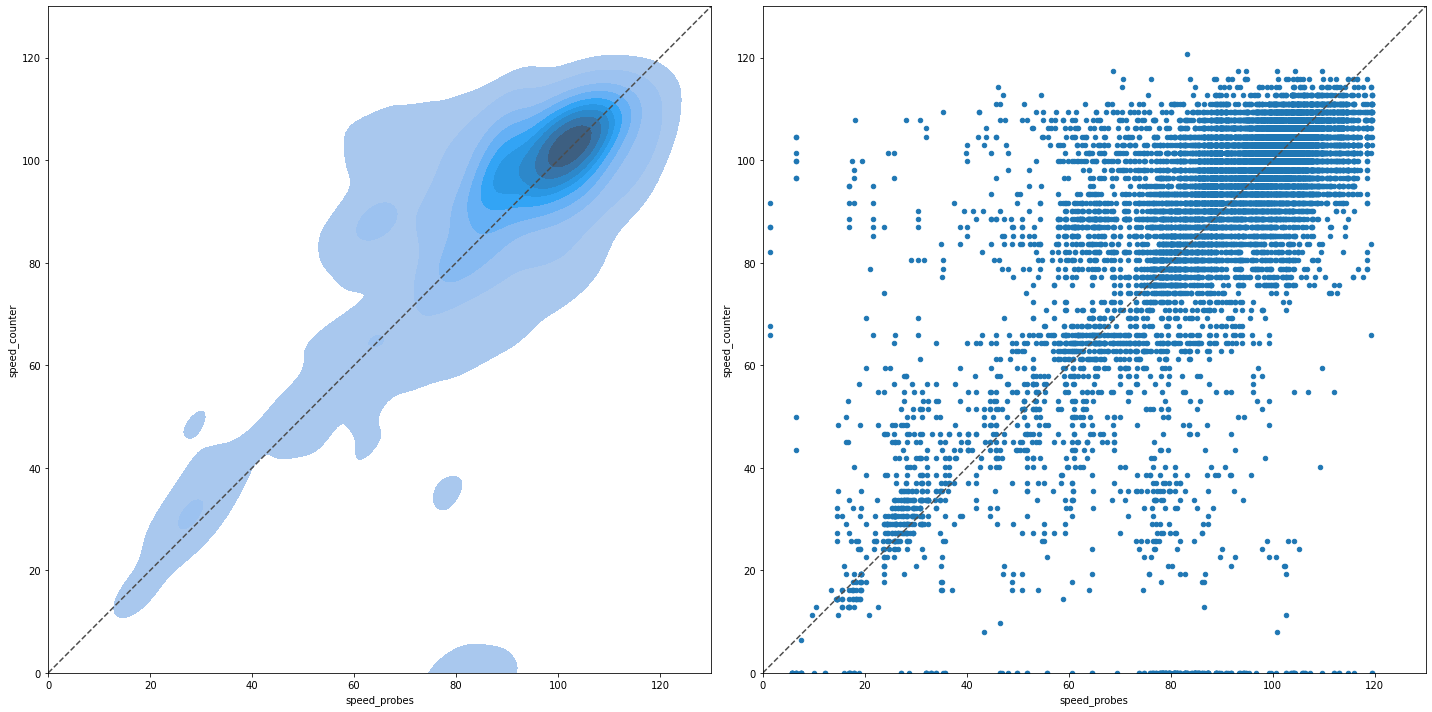

In [79]:
plot_scatters(speeds_merged_nolink)

In [80]:
speeds_merged_nolink.to_parquet(COUNTER_PATH / 'london' / 'speeds_merged_clean_london.parquet', compression="snappy")

Area (x in (0, 40), y in (80, 120) contains 49 / 18839 readings (0.26%)
Readings are on 29 / 202 locations


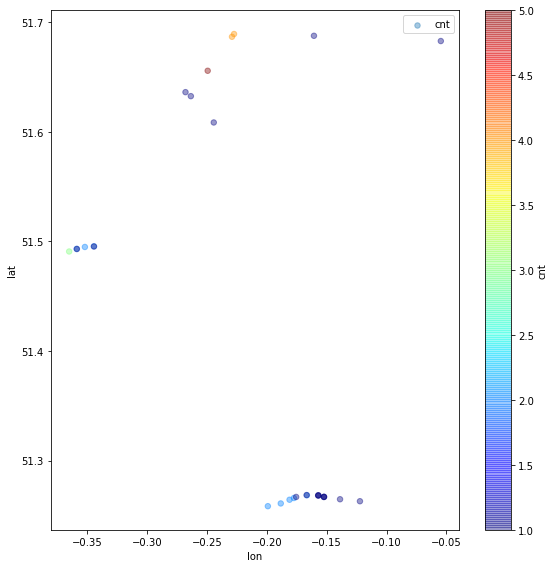

,id,lat,lon,cnt
25,7764,51.655666,-0.249353,5
20,5301,51.689183,-0.227358,4
6,2278,51.686673,-0.229062,4
21,5408,51.490813,-0.365024,3
19,5102,51.494936,-0.351897,2


In [82]:
top_left = inspect_diff_area(speeds_merged_nolink, 0, 40, 80, 120)
top_left.head(5)

Area (x in (40, 75), y in (100, 120) contains 160 / 18839 readings (0.85%)
Readings are on 19 / 202 locations


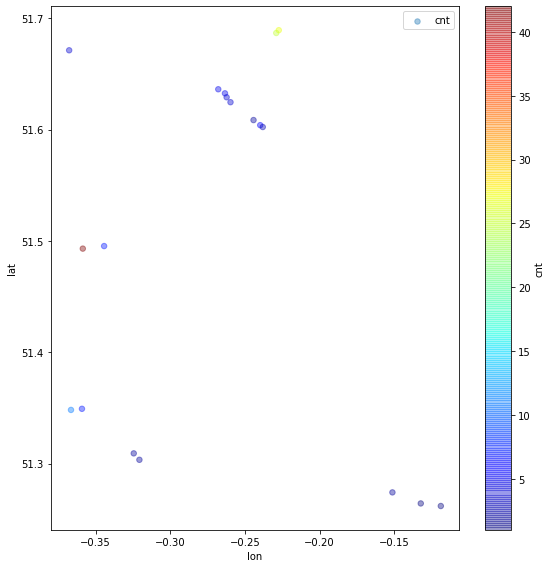

,id,lat,lon,cnt
5,3678,51.493088,-0.358590,42
11,5301,51.689183,-0.227358,27
3,2278,51.686673,-0.229062,25
12,7882,51.348275,-0.366496,11
4,2316,51.495369,-0.344318,7


In [83]:
top_mid = inspect_diff_area(speeds_merged_nolink, 40, 75, 100, 120)
top_mid.head(5)

In [46]:
speeds_merged[speeds_merged['diff'] > 50]

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day_x,way,u,v,gkey,day_y,volume_class,speed_probes,free_flow_kph,diff
1506,665,M25/5489B,51.681267,-0.023327,-1,2020-01-29 21:00,422,99.77908,83,2020-01-29,103849704,196015,257147105,1690766948946526148,2020-01-29,3,46.117647,98.117647,53.661433
1638,815,M25/4517L,51.258525,-0.201205,-1,2020-01-29 09:00,172,43.45218,35,2020-01-29,151067754,1639044958,1639044969,-5547568785144889214,2020-01-29,5,107.529412,112.196078,64.077232
2509,982,M25/4592B,51.291925,-0.286429,-1,2020-01-29 23:15,188,80.46700,92,2020-01-29,34748820,10815135,206226202,-5063587411577038532,2020-01-29,5,2.823529,112.000000,77.643471
2520,956,M25/4617B,51.302321,-0.319324,-1,2020-01-29 03:00,70,102.99776,11,2020-01-29,34748820,206226627,206226551,-7452872976955744657,2020-01-29,5,7.764706,111.372549,95.233054
2598,956,M25/4617B,51.302321,-0.319324,-1,2020-01-29 22:30,292,109.43512,89,2020-01-29,34748820,206226627,206226551,-7452872976955744657,2020-01-29,3,53.764706,111.372549,55.670414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18175,12569,M25/5532L,51.679612,0.037789,-1,2020-01-29 09:45,158,72.42030,38,2020-01-29,4277063,28350866,28350979,1881342101137868358,2020-01-29,5,17.019608,112.000000,55.400692
18816,10463,M25/5508B,51.680834,0.003879,-1,2020-01-29 12:00,959,102.99776,47,2020-01-29,1881102,1413863658,28351748,6501447865789503291,2020-01-29,5,32.470588,111.529412,70.527172
19220,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 20:15,66,65.98294,80,2020-01-29,4277064,12207730,286131186,1175653905212232512,2020-01-29,1,119.058824,102.117647,53.075884
19221,13395,M25/5527M,51.678163,0.032647,-1,2020-01-29 20:45,85,62.76426,82,2020-01-29,4277064,12207730,286131186,1175653905212232512,2020-01-29,1,112.941176,102.117647,50.176916


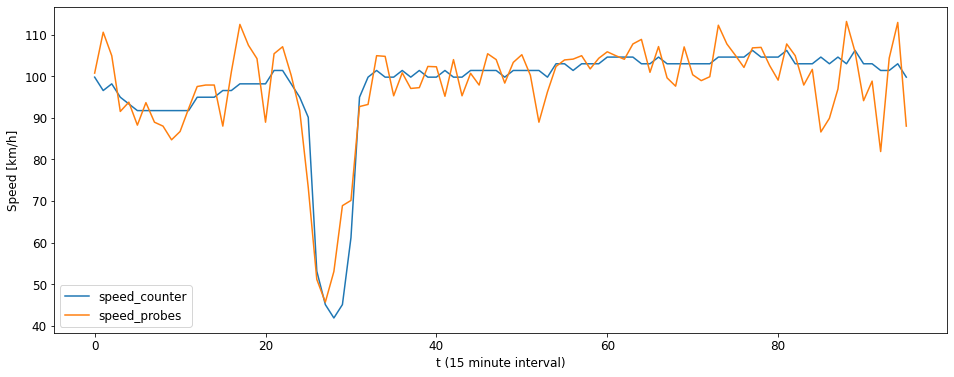

In [84]:
plot_speed_dayline(speeds_merged, '97')
plot_counter(counters_assigned_df, edges_df, '97')

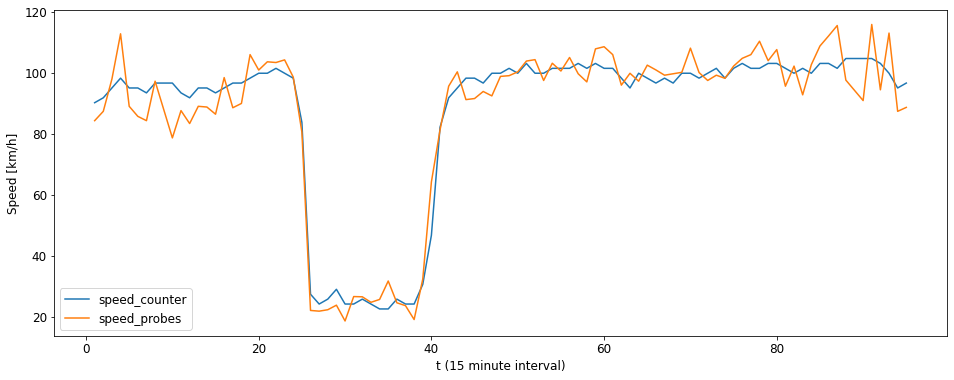

In [85]:
plot_speed_dayline(speeds_merged, '10510')
plot_counter(counters_assigned_df, edges_df, '10510')

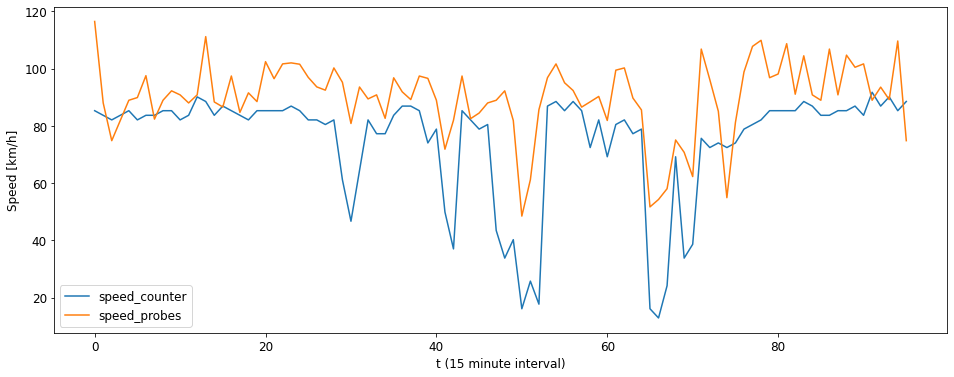

In [86]:
plot_speed_dayline(speeds_merged, '1737')
plot_counter(counters_assigned_df, edges_df, '1737')

In [88]:
# plot_speed_dayline(speeds_merged, '6137', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '6137')